In [3]:
import tensorflow as tf
from keras.models import load_model
import cv2
from tqdm import tqdm
import numpy as np
import pickle
import cv2
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
import shutil
from PIL import Image

In [4]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
width=256
height=256
depth=3

In [5]:
class_names = ['person', 'wall']
class_names_label = {'person': 0, 'wall': 1}

In [6]:
num_classes = len(class_names)
input_dir='/content/images_data'

In [7]:
def process_images(input_dir, target_size=(256, 256), target_format='JPEG'):
    # Get the list of folders in the input directory
    folders = sorted([f for f in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, f))])

    # Process each folder
    for i, folder in enumerate(folders):
        # Create a new directory for the processed images
        output_dir = os.path.join(os.getcwd(), 'processed_images', folder)
        os.makedirs(output_dir, exist_ok=True)

        # Get the list of files in the current folder
        folder_path = os.path.join(input_dir, folder)
        files = os.listdir(folder_path)

        # Process each image file
        for file in files:
            # Check if the file has a JPEG, JPG, or PNG extension
            if file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png'):
                # Load the image
                image_path = os.path.join(folder_path, file)
                image = Image.open(image_path)

                # Convert the image format to JPEG if it's not already in that format
                if image.format != 'JPEG':
                    image = image.convert('RGB')

                # Resize the image
                image = image.resize(target_size, Image.LANCZOS)

                # Convert the image format
                if target_format != 'JPEG':
                    image = image.convert(target_format)

                # Save the processed image
                output_path = os.path.join(output_dir, file)
                output_path = os.path.splitext(output_path)[0] + '.' + target_format.lower()
                image.save(output_path, format=target_format)

    return os.path.join(os.getcwd(), 'processed_images')

In [8]:
datasets = process_images(input_dir, target_size=(256, 256), target_format='JPEG')
datasets

'/content/processed_images'

In [9]:
print("Dictionary keys:", class_names_label.keys())

dataset_path = datasets
print("Loading {}".format(dataset_path))

for folder in os.listdir(dataset_path):
    if folder.startswith('.'):
        continue
    label = class_names_label[folder]
    folder_path = os.path.join(dataset_path, folder)
    print("Folder:", folder)
    print(label)


Dictionary keys: dict_keys(['person', 'wall'])
Loading /content/processed_images
Folder: wall
1
Folder: person
0


In [10]:
def load_dataset(datasets, class_names_label, default_image_size, batch_size=16, augmentation=False, additional_samples=100):
    images = []
    labels = []

    print("Loading {}".format(datasets))

    # Create an ImageDataGenerator for data augmentation
    if augmentation:
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )

    # Create a directory to save the augmented images
    augmented_images_dir = 'augmented_images'
    if augmentation and not os.path.exists(augmented_images_dir):
        os.makedirs(augmented_images_dir)

    # Iterate through each folder corresponding to a category
    for folder in os.listdir(datasets):
        if folder.startswith('.'):
          continue
        label = class_names_label[folder]
        folder_path = os.path.join(datasets, folder)

        # Iterate through each image in the folder
        for file in tqdm(os.listdir(folder_path)):
            # Get the path name of the image
            img_path = os.path.join(folder_path, file)

            # Open and resize the image
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255.0  # Normalize pixel values to [0, 1]
            image = cv2.resize(image, default_image_size)

            # Append the original image and its corresponding label to the output
            images.append(image)
            labels.append(label)

            # Augment the image if augmentation is enabled
            if augmentation:
                # Generate additional augmented samples
                augmented_images = datagen.flow(np.expand_dims(image, axis=0), batch_size=additional_samples)
                augmented_images = augmented_images[0]  # Retrieve the augmented images from the flow

                # Save the augmented images to disk and append to the list
                for i, augmented_image in enumerate(augmented_images):
                    augmented_image = augmented_image.astype(np.float32)
                    images.append(augmented_image)
                    labels.append(label)

                    # Save the augmented image to disk
                    augmented_image_path = os.path.join(augmented_images_dir, f'{file[:-4]}_augmented_{i}.jpg')
                    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    # Create a Dataset object from the arrays
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(len(images)).batch(batch_size)

    return dataset, images, labels

# Usage example:
dataset, images, labels= load_dataset(datasets, class_names_label, (256, 256))

Loading /content/processed_images


100%|██████████| 1000/1000 [00:02<00:00, 373.24it/s]


In [11]:
def explore_dataset(dataset):
    num_training_examples = 0
    image_size = None
    categories = {}

    for images, labels in dataset:
        num_training_examples += images.shape[0]

        if image_size is None:
            image_size = images.shape[1:3]

        labels = labels.numpy()

        for label in labels:
            if label not in categories:
                categories[label] = 0
            categories[label] += 1

    num_categories = len(categories)

    print("Dataset Exploration:")
    print("Number of examples: {}".format(num_training_examples))
    print("Image size: {}".format(image_size))
    print("Proportion of each category:")

    for category, count in categories.items():
        proportion = count / num_training_examples * 100
        print("Category {}: {} examples ({:.2f}%)".format(category, count, proportion))

# Explore the train and test datasets
explore_dataset(dataset)

Dataset Exploration:
Number of examples: 1701
Image size: (256, 256)
Proportion of each category:
Category 0: 1000 examples (58.79%)
Category 1: 701 examples (41.21%)


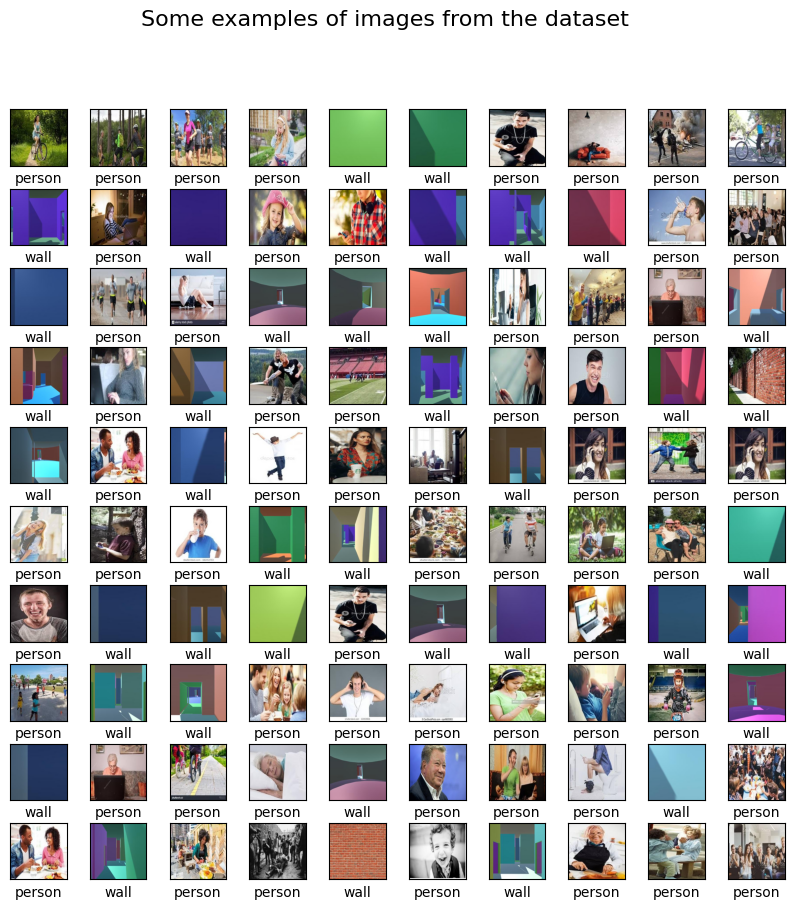

In [12]:
def display_random_images(class_names, images, labels):
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    fig.suptitle("Some examples of images from the dataset", fontsize=16)

    for i, ax in enumerate(axes.flat):
        index = np.random.randint(images.shape[0])
        image = images[index]
        label = labels[index]
        ax.imshow(image, cmap=plt.cm.binary)
        ax.set(xticks=[], yticks=[], xlabel=class_names[label])

    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

display_random_images(class_names, images, labels)

In [20]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation("softmax"))

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 activation_7 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 85, 85, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 85, 85, 64)       

In [22]:
learning_rate = INIT_LR
decay_rate = learning_rate / EPOCHS

opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=decay_rate)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [23]:
from sklearn.preprocessing import LabelEncoder
import pickle

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Save the label encoder for later use
pickle.dump(label_encoder, open('label_transform.pkl', 'wb'))

n_classes = len(label_encoder.classes_)

In [24]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [25]:
np_image_list = np.array(images, dtype=np.float16)
#np_image_list = np_image_list.reshape(-1, height, width, 3)  # Reshape the array to match the desired shape
x_train, x_test, y_train, y_test = train_test_split(np_image_list, labels, test_size=0.2, random_state=42)


In [26]:
# Reshape the input data
x_train = x_train.reshape(-1, height, width, 3)
x_test = x_test.reshape(-1, height, width, 3)

# Convert labels to one-hot encoded vectors
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Train the model
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/25
42/42 [==============================] - 425s 10s/step - loss: 0.3373 - accuracy: 0.9194 - val_loss: 1.3617 - val_accuracy: 0.4604
Epoch 2/25
42/42 [==============================] - 412s 10s/step - loss: 0.1350 - accuracy: 0.9706 - val_loss: 0.8491 - val_accuracy: 0.5777
Epoch 3/25
42/42 [==============================] - 413s 10s/step - loss: 0.0808 - accuracy: 0.9797 - val_loss: 1.0881 - val_accuracy: 0.4370
Epoch 4/25
42/42 [==============================] - 418s 10s/step - loss: 0.1020 - accuracy: 0.9729 - val_loss: 0.5374 - val_accuracy: 0.7361
Epoch 5/25
42/42 [==============================] - 411s 10s/step - loss: 0.0962 - accuracy: 0.9819 - val_loss: 1.0610 - val_accuracy: 0.5455
Epoch 6/25
42/42 [==============================] - 410s 10s/step - loss: 0.0806 - accuracy: 0.9819 - val_loss: 0.7310 - val_accuracy: 0.6158
Epoch 7/25
42/42 [==============================] - 409s 10s/step - loss: 0.0737 - accuracy: 0.9819 - val_loss: 0.8117 - val_accuracy: 0.6246
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


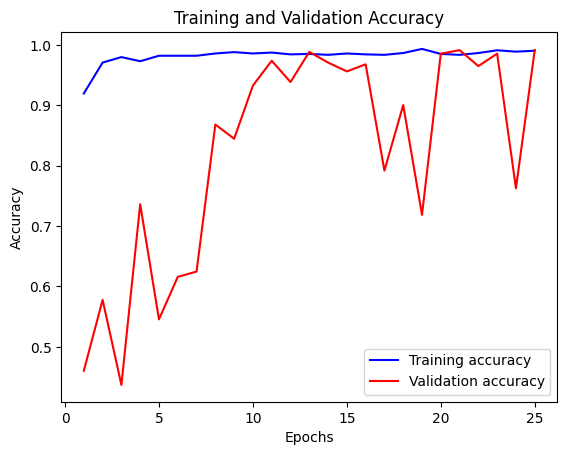

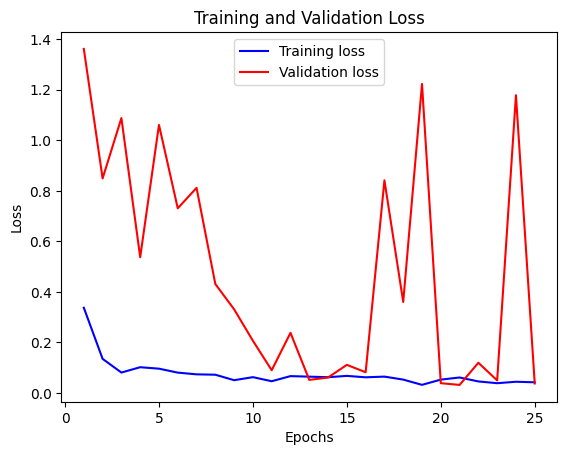

In [29]:
# Print the keys in the history.history dictionary
print(history.history.keys())

# Retrieve the accuracy and loss values using the correct keys
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the epochs variable
epochs = range(1, len(acc) + 1)

# Plot the accuracy curve
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curve
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

11/11 [==============================] - 22s 2s/step - loss: 0.0375 - accuracy: 0.9912
Test Accuracy: 99.12023544311523


In [ ]:
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Open the webcam in Google Colab
#camera = cv2.VideoCapture(0)


# Use the take_photo() function to capture an image
image_path = take_photo()

# Read the captured image
frame = cv2.imread(image_path)

# Check if the image retrieval was successful
if frame is None:
    print("Failed to retrieve frame from the captured image")

# Resize the raw image into (256-height, 256-width) pixels
image = cv2.resize(frame, (256, 256), interpolation=cv2.INTER_AREA)

# Show the image in a window
print(cv2_imshow(image))

# Make the image a numpy array and reshape it to the model's input shape
image = np.asarray(image, dtype=np.float32).reshape(1, 256, 256, 3)

# Normalize the image array
image = (image / 127.5) - 1

# Predict the model
prediction = model.predict(image)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name, "\n")
print("Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")



In [32]:
# save the model to disk`qww1
pickle.dump(model,open('cnn_model.pkl', 'wb'))